In [1]:
import pandas as pd 
import numpy as np 

df = pd.read_csv("OMC_CSV_final.csv" , sep=";")

df = df.copy()


df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"] , format="%d/%m/%Y" , errors='coerce')

# Convert Date column to datetime if not already done
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")

# Define a cutoff date (e.g., 80% of data)
cutoff_date = df["Date"].quantile(0.8)

train_df = df[df["Date"] <= cutoff_date]
test_df  = df[df["Date"] > cutoff_date]

print(f"Train rows: {len(train_df)}")
print(f"Test rows:  {len(test_df)}")



Train rows: 68393
Test rows:  16270


In [3]:
features_cols = ["Call Drop Rate", "SDCCH drop rate", "RTCH Assignment Fail Rate"]
target_col = "Call Drop Rate"
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(df[features_cols].values)
scaler_y.fit(df[[target_col]].values)

site_names =  df["Site"].unique().tolist()
cell_names = df["Cell"].unique().tolist()
print(len(site_names))
print(len(cell_names))
site_to_id = {name:idx for idx,name in enumerate(site_names)}
cell_to_id = {name:idx for idx,name in enumerate(cell_names)}
seq_len = 15
all_seq = []

for site in site_names:
    site_df = df[df["Site"] == site].sort_values("Date")
    site_df = site_df[["Date","Cell"] + features_cols].dropna()
    cells_in_site = site_df["Cell"].unique()
    
    for cell in cells_in_site:
        cell_df = site_df[site_df["Cell"] == cell].sort_values("Date")
        if len(cell_df) < seq_len + 1:
            continue
        
        features = scaler_x.transform(cell_df[features_cols].astype(float).values)
        cdr = scaler_y.transform(cell_df[["Call Drop Rate"]].astype(float).values).flatten()
        dates = cell_df["Date"].values
        
        for i in range(len(features) - seq_len):
            x = features[i:i+seq_len]
            y = cdr[i + seq_len]
            end_date = dates[i + seq_len]  # last date of the window
            
            site_id = site_to_id[site]
            cell_id = cell_to_id[cell]
            all_seq.append((x, site_id, cell_id, y, end_date))

print(f"Total sequences: {len(all_seq)}")

515
2004
Total sequences: 54018


In [5]:
cutoff_date = np.percentile([s[4] for s in all_seq], 80)  # 80% split

train_seq = [s[:4] for s in all_seq if s[4] <= cutoff_date]
test_seq  = [s[:4] for s in all_seq if s[4] >  cutoff_date]

print(f"Train sequences: {len(train_seq)}")
print(f"Test sequences:  {len(test_seq)}")


Train sequences: 43984
Test sequences:  10034


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class KPIGPTDataset(Dataset):
    def __init__(self, seq_tuples, dtype=torch.float32):
        self.seq_tuples = seq_tuples
        self.dtype = dtype
    
    def __len__(self):
        return len(self.seq_tuples)
    
    def __getitem__(self, idx):
        x, site_id, cell_id, y = self.seq_tuples[idx]
        x = torch.tensor(x, dtype=self.dtype)             # (T, F)
        site_id = torch.tensor(site_id, dtype=torch.long) # categorical
        cell_id = torch.tensor(cell_id, dtype=torch.long) # categorical
        y = torch.tensor(y, dtype=self.dtype)             # scalar
        return x, site_id, cell_id, y


In [7]:

train_dataset= KPIGPTDataset(train_seq)
test_dataset= KPIGPTDataset(test_seq)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)

In [8]:
for input_  in train_loader : 
    pass
print(input_)

[tensor([[[0.0090, 0.0097, 0.0521],
         [0.0071, 0.0095, 0.0498],
         [0.0098, 0.0082, 0.0500],
         ...,
         [0.0084, 0.0073, 0.0555],
         [0.0083, 0.0068, 0.0519],
         [0.0095, 0.0058, 0.1096]],

        [[0.0690, 0.1096, 0.1302],
         [0.0417, 0.1937, 0.1475],
         [0.0453, 0.1671, 0.1365],
         ...,
         [0.0454, 0.1018, 0.1378],
         [0.0545, 0.1035, 0.1122],
         [0.0388, 0.1069, 0.0942]],

        [[0.0135, 0.0388, 0.0634],
         [0.0240, 0.0727, 0.0592],
         [0.0227, 0.0645, 0.0917],
         ...,
         [0.0043, 0.2900, 0.0556],
         [0.0108, 0.2776, 0.0591],
         [0.0182, 0.3868, 0.0633]],

        ...,

        [[0.0053, 0.0119, 0.0476],
         [0.0047, 0.0138, 0.0489],
         [0.0055, 0.0129, 0.0503],
         ...,
         [0.0098, 0.0107, 0.0502],
         [0.0079, 0.0121, 0.0505],
         [0.0065, 0.0116, 0.0495]],

        [[0.0063, 0.0213, 0.0509],
         [0.0081, 0.0371, 0.0484],
         [0

In [9]:
import torch.nn as nn

In [10]:
class MultiHeadAttention(nn.Module) : 
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,bias=False):
        super().__init__()
        assert(d_out % num_heads ==0 ) ,"d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        
        self.head_dim = d_out // num_heads
        
        self.w_q = nn.Linear(d_in,d_out,bias=bias)
        self.w_k = nn.Linear(d_in,d_out,bias=bias)
        self.w_v = nn.Linear(d_in,d_out,bias=bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout  = nn.Dropout(dropout) 
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
    
    def forward(self,x):
        b,num_tokens,d_embed= x.shape
        
        queries = self.w_q(x) ## (b , num_tokens , d_out)
        #print(f"queries :\n {queries}")
        keys    = self.w_k(x) ## (b , num_tokens , d_out)
        #print(f"keys    : \n {keys}")
        values  = self.w_v(x) ## (b , num_tokens , d_out)
        #print(f"values  : \n {values}")
        ## (b , num_tokens , d_out) -------->  (b , num_tokens , num_heads , head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        keys    = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values  = values.view(b,num_tokens,self.num_heads,self.head_dim)
        #print(f"queries after view :\n {queries}")
        #print(f"keys after view    :\n {keys}")
        #print(f"values after view  :\n {values}")
        # (b , num_tokens , num_heads , head_dim) ------> (b , num_heads , num_tokens , head_dim)
        ## in this case each head should be able to access all the tokens but with different embeddings (keys values splitted over the different heads)
        keys    = keys.transpose(1,2) 
        queries = queries.transpose(1,2) 
        values  = values.transpose(1,2) 
        #print(f"queries after transpose :\n {queries}")
        #print(f"keys after transpose    :\n {keys}")
        #print(f"values after transpose  :\n {values}")
        attn_scores = queries @ keys.transpose(-1,-2)
        #print(f"Attention Scores : \n {attn_scores}")
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores_masked = attn_scores.masked_fill_(mask_bool,-torch.inf)
        #print(f"Attention Scores masked : \n {attn_scores_masked}")
        attn_weights = F.softmax(attn_scores_masked / keys.shape[-1]**0.5,dim=-1)
        #print(f"Attention Weights : \n {attn_weights}")
        attn_weights = self.dropout(attn_weights)
        
        context = ( attn_weights @ values ).transpose(1,2)# (b , num_heads , num_tokens , head_dim) ------> (b , num_tokens , num_heads , head_dim) 
        
        context = context.contiguous().view(b,num_tokens,self.d_out)
        
        context = self.out_proj(context) # optional linear projection layer 
        
        return context

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.MHattention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            bias=cfg["qkv_bias"]
        )
        self.layer_norm_1 = LayerNorm(emb_dim=cfg['emb_dim'])
        self.layer_norm_2 = LayerNorm(emb_dim=cfg['emb_dim'])
        self.ffn          = FeedForward(cfg)
        self.dropout      = nn.Dropout(cfg["drop_rate"])
        
        
    def forward(self,x) : 
        res_1 = x 
        x = self.layer_norm_1(x)
        x = self.MHattention(x)
        x = self.dropout(x)
        x = x + res_1
        
        res_2 = x 
        
        x = self.layer_norm_2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = x + res_2
        
        return x 

## building the layer normalization class 
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5 ## since we are dividing by the square root of the variance , we use eps to prevent division by zero 
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        ## scale and shift are learned parameters that the model can update if this can enhance the training
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        
class FeedForward(nn.Module): 
    def __init__(self,cfg) : 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"] , 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"] , cfg["emb_dim"])
        )
    def forward(self,x):
        return self.layers(x)
    

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5*x*(1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))


In [11]:
### building the GPT like model : 

class KPIGPTModel(nn.Module) : 
    def __init__(self,cfg) : 
        super().__init__()
        self.emb_dim = cfg["emb_dim"]
        self.context_length = cfg["context_length"]
        
        ## projection layer ==> (n_features) --> (n_features , emb_dim) (input embedding)
        self.features_proj = nn.Linear(cfg["n_features"] , self.emb_dim)
        
        ## categorical features embeddings 
        self.site_emb = nn.Embedding(cfg["n_sites"] , self.emb_dim)
        self.cell_emb = nn.Embedding(cfg["n_cells"] , self.emb_dim)
        
        ## position embedding : 
        self.pos_emb = nn.Embedding(self.context_length , self.emb_dim)
        
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = LayerNorm(self.emb_dim)
        
        ## Regression 
        self.out_head = nn.Linear(self.emb_dim,1,bias=True)
        
    def forward(self,x_feat , site_id , cell_id) : 
        """
        x_feat: (B, T, F) scaled features history
        site_id: (B,) categorical site indices
        cell_id: (B,) categorical cell indices
        """
        B,T,F  = x_feat.shape
        assert T <= self.context_length  , "Sequence longer than context length"
        
        x = self.features_proj(x_feat) ## (B,T,emb_dim)
        site_e = self.site_emb(site_id)[:,None,:] # (B,1,E)        
        cell_e = self.cell_emb(cell_id)[:,None,:] # (B,1,E)     
        x = x + site_e  + cell_e
        pos_idx = torch.arange(T,device=x.device)
        pos_e = self.pos_emb(pos_idx)[None,:,:] # (1,T,E)
        x = x+pos_e
        
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        last_h = x[:,-1,:] # (B,E)
        pred_next = self.out_head(last_h) # (B,1)
        return pred_next.squeeze(-1) ## (B,)
        

In [12]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch.nn.functional as F
seq_len = 15
cfg = {
    "emb_dim": 128,
    "context_length": seq_len,
    "n_heads": 8,
    "n_layers": 6,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "n_features": 3,
    "n_sites": 515,
    "n_cells": 2005,
}

model = KPIGPTModel(cfg) 
optimizer = torch.optim.AdamW(model.parameters() , lr=0.00005,weight_decay=0.01)

num_epochs = 25 
model = model.to(device)

for epoch in range(num_epochs) : 
    model.train()
    total_train , n= 0.0 ,0
    for x_feat , site_id , cell_id , y_target in train_loader : 
         x_feat , site_id , cell_id , y_target = x_feat.to(device) , site_id.to(device) , cell_id.to(device) , y_target.to(device)
         optimizer.zero_grad()
         
         y_hat = model(x_feat , site_id , cell_id)
         loss = F.mse_loss(y_hat,y_target)
         loss.backward()
         optimizer.step()
         
         total_train += loss.item() * x_feat.size(0)
    train_loss = total_train / n if n > 0 else float("nan")
    
    model.eval()
    total_val , n= 0.0 ,0
    for x_feat , site_id , cell_id , y_target in test_loader : 
         x_feat , site_id , cell_id , y_target = x_feat.to(device) , site_id.to(device) , cell_id.to(device) , y_target.to(device)
         y_hat = model(x_feat , site_id , cell_id)
         loss = F.mse_loss(y_hat,y_target)
         
         total_val += loss.item() * x_feat.size(0)
    val_loss = total_val / n if n > 0 else float("nan")
    
    print(f"Epoch {epoch+1} | Train MSE : {train_loss:.3f} -- Validation MSE : {val_loss:3.f}")

In [14]:
cfg = {
    "emb_dim": 128,
    "context_length": seq_len,
    "n_heads": 8,
    "n_layers": 6,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "n_features": 3,
    "n_sites": 515,
    "n_cells": 2005,
}
model_fine_tuned = KPIGPTModel(cfg)
state_dict= torch.load("time_series_gpt.pth" , weights_only=True)
model_fine_tuned.load_state_dict(state_dict)
model_fine_tuned.to(device)
model_fine_tuned.eval()

KPIGPTModel(
  (features_proj): Linear(in_features=3, out_features=128, bias=True)
  (site_emb): Embedding(515, 128)
  (cell_emb): Embedding(2005, 128)
  (pos_emb): Embedding(15, 128)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (MHattention): MultiHeadAttention(
        (w_q): Linear(in_features=128, out_features=128, bias=False)
        (w_k): Linear(in_features=128, out_features=128, bias=False)
        (w_v): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm_1): LayerNorm()
      (layer_norm_2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace

In [ ]:
import torch.nn.functional as F

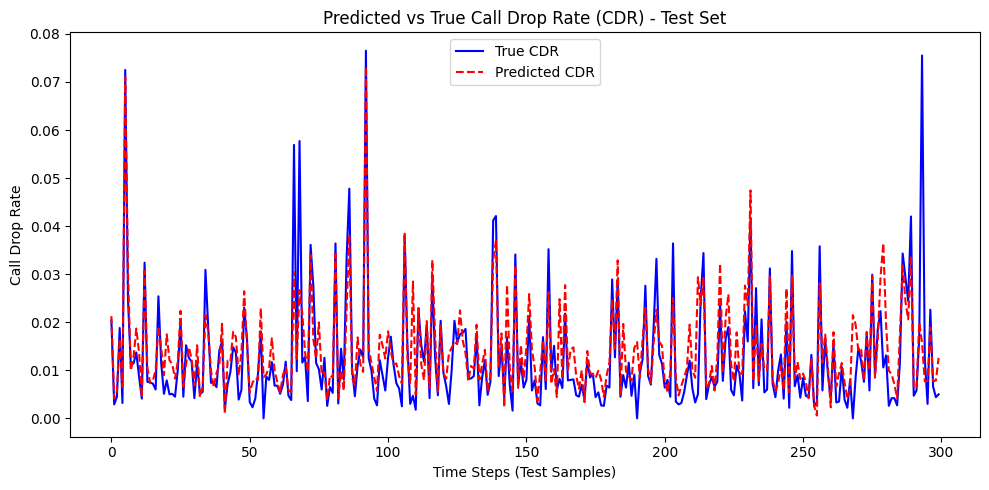

In [18]:
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
import matplotlib.pyplot as plt
import numpy as np

all_preds, all_true = [], []

with torch.no_grad():
    for x_feat, site_id, cell_id, y in test_loader:
        x_feat = x_feat.to(device)
        site_id = site_id.to(device)
        cell_id = cell_id.to(device)
        y = y.to(device)

        y_hat = model_fine_tuned(x_feat, site_id, cell_id)  # Shape [batch_size, 1] or [batch_size]
        all_preds.append(y_hat.cpu().numpy())
        all_true.append(y.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds).reshape(-1, 1)
all_true = np.concatenate(all_true).reshape(-1, 1)

# Inverse transform (to original CDR values)
all_preds = scaler_y.inverse_transform(all_preds)
all_true = scaler_y.inverse_transform(all_true)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(all_true[:300], label="True CDR", color='blue')
plt.plot(all_preds[:300], label="Predicted CDR", color='red', linestyle='--')
plt.title("Predicted vs True Call Drop Rate (CDR) - Test Set")
plt.xlabel("Time Steps (Test Samples)")
plt.ylabel("Call Drop Rate")
plt.legend()
plt.tight_layout()
plt.show()


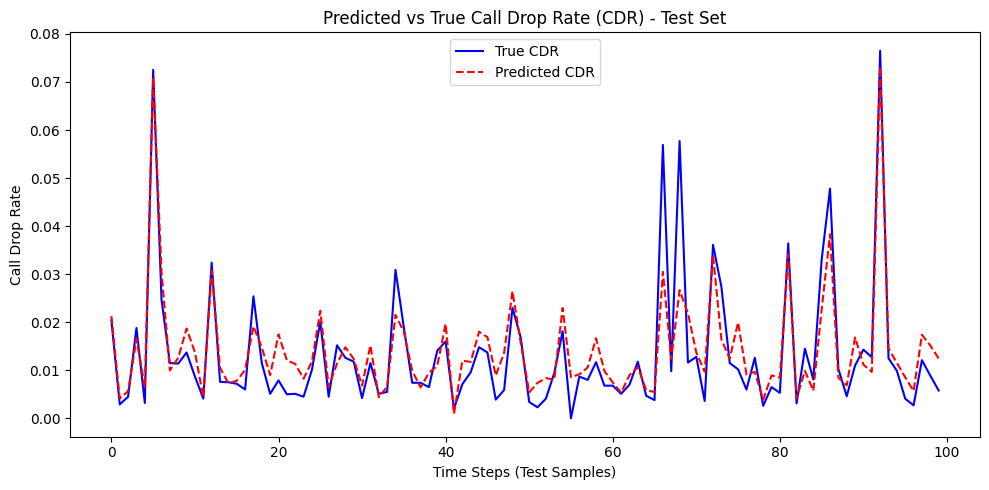

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(all_true[:100], label="True CDR", color='blue')
plt.plot(all_preds[:100], label="Predicted CDR", color='red', linestyle='--')
plt.title("Predicted vs True Call Drop Rate (CDR) - Test Set")
plt.xlabel("Time Steps (Test Samples)")
plt.ylabel("Call Drop Rate")
plt.legend()
plt.tight_layout()
plt.show()